# Preparing Dataset for Modeling

In [1]:
# dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# load the data from our income dataset
df = pd.read_csv("data/adult-income.csv")

In [3]:
# load the head and see what's going on
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [4]:
# drop all nan columns
df = df.dropna()

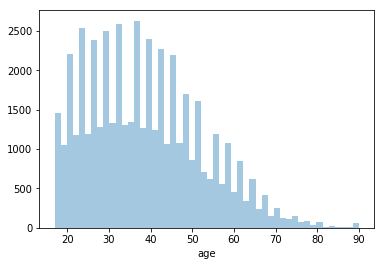

In [5]:
sns.distplot(df["age"], kde=False)

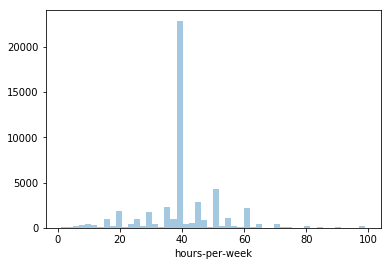

In [6]:
sns.distplot(df["hours-per-week"], kde=False)

In [7]:
df["native-country"].value_counts()

United-States                 43832
Mexico                          951
?                               857
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Nicaragua                        49
Greece                           49
Peru                        

#### Since we don't want too many features for Country, let's convert to United States, and Other, so we have 2 features

In [8]:
df["native-country"] = df["native-country"].apply(lambda country: country if country == "United-States" else "Other")

In [9]:
mutable_df = df.copy()

In [10]:
mutable_df["income"] = mutable_df["income"].apply(lambda income: 1 if income == ">50K" else 0)

# create our features, and our target variable
features = mutable_df.drop(columns=["income"])
# drop some other fields we will not use
features = features.drop(columns=["fnlwgt", "educational-num", "relationship"])
target = mutable_df["income"]

In [11]:
# now do some feature engineering.
# first, turn the categorical variables into usable features
# create a function to automate this for the features we'd like
def create_dummies_using(target_df, base_features):
    # for this function we're continuously modifying the target df
    # to add the dummies, and will return it at the end
    for base_feature in base_features:
        dummies = pd.get_dummies(target_df[base_feature], prefix=base_feature)
        target_df = target_df.drop(columns=[base_feature])
        target_df = pd.concat([target_df, dummies], axis=1)
    
    return target_df
   

In [12]:
# get our extra engineered features
feature_list = ["workclass", "education", "marital-status", "occupation", "race", "gender", "native-country"]

features = create_dummies_using(features, feature_list)

In [13]:
features.head()

,age,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,occupation_Transport-moving,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,gender_Female,gender_Male,native-country_Other,native-country_United-States
0,25,0,0,40,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
1,38,0,0,50,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,1
2,28,0,0,40,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,1
3,44,7688,0,40,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
4,18,0,0,30,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1


### Create the Model

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

In [15]:
# split up our training and testing sets

X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.70, random_state=1)

In [16]:
# create the model

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
# measure the accuracy
predictions = [prediction[1] for prediction in model.predict_proba(X_test)]

accuracy = roc_auc_score(y_test, predictions)

print("Accuracy: {}".format(accuracy))

Accuracy: 0.9035961209519505


In [23]:
curve = roc_curve(y_test, predictions)

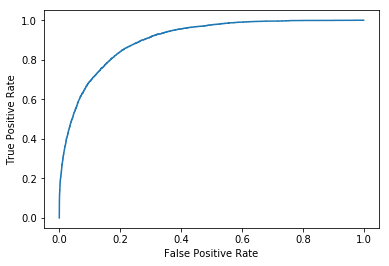

In [29]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, predictions)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(false_positive_rate, true_positive_rate, label="data 1, auc="+str(accuracy))